In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.distributions import Normal
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

Define arbitrary model (doesn't matter which one)

In [0]:
class Mnist_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.model(x)

Define train end eval loop

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')

In [0]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define dataset and transforms

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True}
batch_size = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor()
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
model = Mnist_Model().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [9]:
for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.337423



Test set: Average loss: 0.1846, Accuracy: 9447/10000 (94%)



Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.235916



Test set: Average loss: 0.0952, Accuracy: 9696/10000 (97%)



Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.143776



Test set: Average loss: 0.0770, Accuracy: 9753/10000 (98%)



Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.130436



Test set: Average loss: 0.0625, Accuracy: 9805/10000 (98%)



Prepare test data for adverserial attack

In [0]:
test_inputs = torch.cat([x[0] for x in test_loader])
test_classes = torch.cat([x[1] for x in test_loader])

Let's check how good our model before attack

In [0]:
def plot_predictions(model, inputs, classes, original_predictions=None, device=device):
    predictions = model(inputs.to(device)).argmax(dim=1)
    fig = plt.figure(figsize=(10, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(inputs[i][0], cmap="gray", interpolation="none")
        title = f"Predicition: {predictions[i].item()}\n Ground truth: {classes[i]}"
        if original_predictions is not None:
            title += f"\nOriginal prediction: {original_predictions[i].item()}"
        plt.title(title, {"fontsize": 10})
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

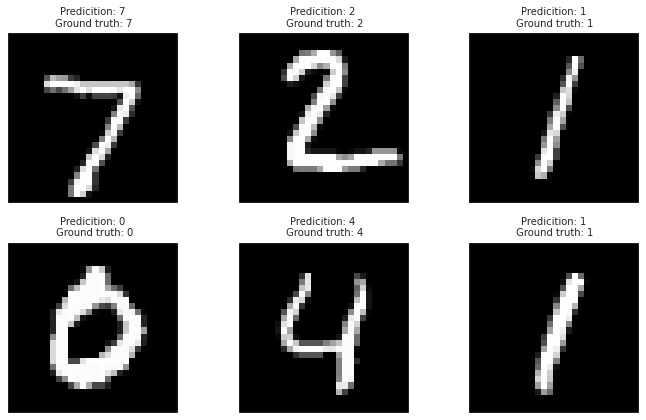

In [12]:
plot_predictions(model, test_inputs, test_classes)

In [0]:
def plot_confusion_matrix(cm, n_classes=10):
    df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}, fmt="d")

In [0]:
original_preds = model(test_inputs.to(device)).argmax(dim=1).cpu()

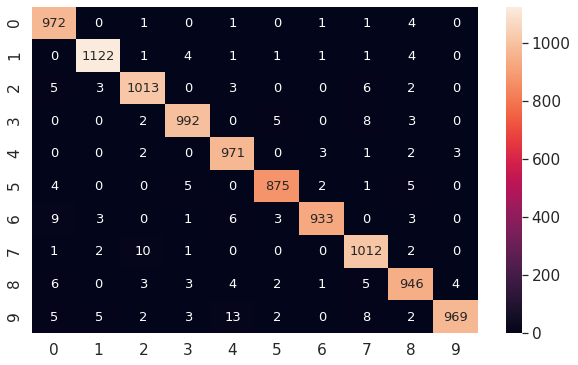

In [15]:
cm = confusion_matrix(test_classes, original_preds)
plot_confusion_matrix(cm)

In [16]:
print(f"Before attack:\naccuracy score: {accuracy_score(test_classes, original_preds)}\nf1 score: {f1_score(test_classes, original_preds, average='micro')}")

Before attack:
accuracy score: 0.9805
f1 score: 0.9805


Based on [EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES](https://arxiv.org/pdf/1412.6572.pdf)

In [0]:
def fast_adversarial_example(target_digit, model, eta=0.01, iters=24, device=device):
    y = torch.tensor([target_digit], dtype=torch.long, device=device)
    x = torch.as_tensor(Normal(loc=0, scale=0.01).sample((1, 1, 28, 28)), device=device).requires_grad_(True)
    for _ in range(iters):
        y_hat = model(x)
        loss = F.nll_loss(y_hat, y)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            x -= eta * x.grad.sign()
            x.clamp_(0, 1)
    return x

In [0]:
example = fast_adversarial_example(3, model)

How adversarial example looks like:

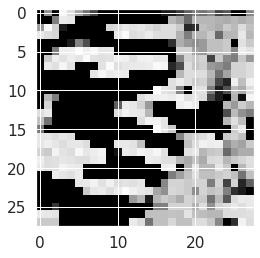

In [19]:
plt.imshow(example.squeeze().cpu().detach().numpy(), cmap="gray", interpolation="none")
plt.show()

In [20]:
print("model predict:", model(example).argmax(dim=1).item())

model predict: 3


In [0]:
alpha = 0.7  # mixture coefficient

In [0]:
X_spoiled = torch.max((1.0 - alpha) * test_inputs.to(device), alpha * example)

In [0]:
spoiled_preds = model(X_spoiled).argmax(dim=1).cpu()

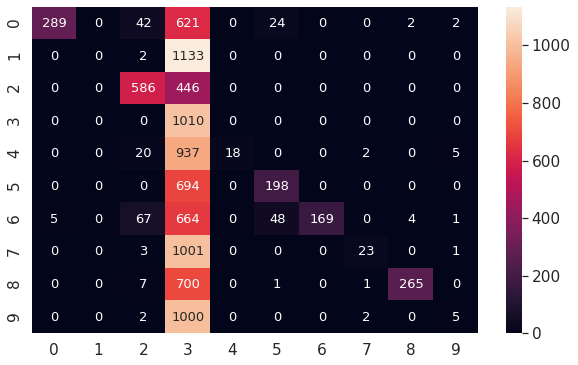

In [24]:
cm = confusion_matrix(test_classes, spoiled_preds)
plot_confusion_matrix(cm)

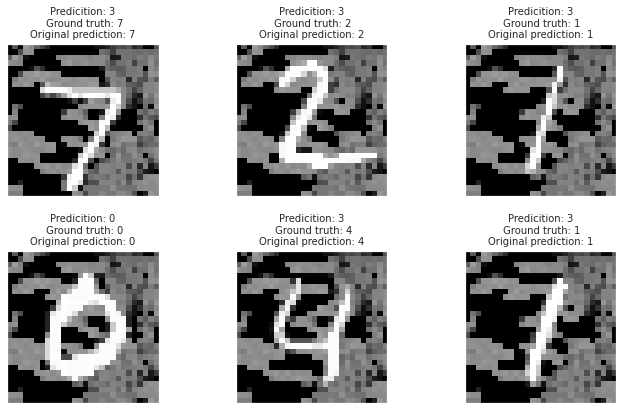

In [25]:
plot_predictions(model, X_spoiled.detach().cpu(), test_classes, original_preds)

In [26]:
print(f"After attack:\naccuracy score: {accuracy_score(test_classes, spoiled_preds)}\nf1 score: {f1_score(test_classes, spoiled_preds, average='micro')}")

After attack:
accuracy score: 0.2563
f1 score: 0.2563


Attack is successful!